In [6]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import os
import numpy as np
from matplotlib import pyplot as plt
import keras
import glob
import random
import segmentation_models_3D as sm

2023-05-08 08:14:42.712878: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Segmentation Models: using `tf.keras` framework.


In [7]:
kernel_initializer =  'he_uniform'

'''
This is a 3D Unet Model implementation.
'''
def UNet_3D(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible. 
    model.summary()
    
    return model

In [8]:
'''
This is a function to load a image represented as a numpy array.
'''
def load_img(path, lst):
    imgs = []
    for i, name in enumerate(lst): 
        
        if (name.split('.')[1] == 'npy'):
            
            img = np.load(path + name) 
            imgs.append(img)
            
    imgs = np.array(imgs)
    
    return(imgs)

'''
This is a custom data generator for numpy array.
'''
def Data_Generator(path_train, train_list, path_mask, mask_list, batch_size):
    
    length = len(train_list)
    
    while True:
        
        count = 0
        end = batch_size
        
        while count < length:
            
            max = min(length, end)
            img = load_img(path_train, train_list[count:max])
            mask = load_img(path_mask, mask_list[count:max])
            
            count += batch_size
            end += batch_size
            
            yield (img, mask)

In [9]:
img_train_path = 'BraTS2020_TrainingData/train_val/train/processed_imgs/'
mask_train_path = 'BraTS2020_TrainingData/train_val/train/processed_masks/'
img_train_set = os.listdir(img_train_path)
mask_train_set = os.listdir(mask_train_path)

img_val_path = 'BraTS2020_TrainingData/train_val/val/processed_imgs/'
mask_val_path = 'BraTS2020_TrainingData/train_val/val/processed_masks/'
img_val_set = os.listdir(img_val_path)
mask_val_set = os.listdir(mask_val_path)

In [10]:
train_generator = Data_Generator(img_train_path, img_train_set, mask_train_path, mask_train_set, 2)
val_generator = Data_Generator(img_val_path, img_val_set, mask_val_path, mask_val_set, 2)

In [11]:
loss = sm.losses.DiceLoss(class_weights = np.array([0.25, 0.25, 0.25, 0.25])) + sm.losses.CategoricalFocalLoss()
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]
model = UNet_3D(128, 128, 128, 3, 4)
model.compile(optimizer = keras.optimizers.Adam(0.001), loss = loss, metrics = metrics)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

Epoch 1/10
81/81 [==============================] - 6450s 79s/step - loss: 0.9497 - accuracy: 0.9442 - iou_score: 0.2300 - val_loss: 0.9424 - val_accuracy: 0.9493 - val_iou_score: 0.2367
Epoch 2/10
81/81 [==============================] - 5912s 73s/step - loss: 0.9423 - accuracy: 0.9574 - iou_score: 0.2393 - val_loss: 0.9417 - val_accuracy: 0.9493 - val_iou_score: 0.2373
Epoch 3/10
81/81 [==============================] - 5624s 69s/step - loss: 0.9408 - accuracy: 0.9573 - iou_score: 0.2393 - val_loss: 0.9389 - val_accuracy: 0.9493 - val_iou_score: 0.2373
Epoch 4/10
81/81 [==============================] - 5722s 71s/step - loss: 0.9400 - accuracy: 0.9573 - iou_score: 0.2393 - val_loss: 0.9383 - val_accuracy: 0.9493 - val_iou_score: 0.2373
Epoch 5/10
81/81 [==============================] - 5726s 71s/step - loss: 0.9398 - accuracy: 0.9576 - iou_score: 0.2394 - val_loss: 0.9382 - val_accuracy: 0.9493 - val_iou_score: 0.2373
Epoch 6/10
81/81 [==============================] - 5766s 71s/ste

INFO:tensorflow:Assets written to: my_model_1/assets


INFO:tensorflow:Assets written to: my_model_1/assets


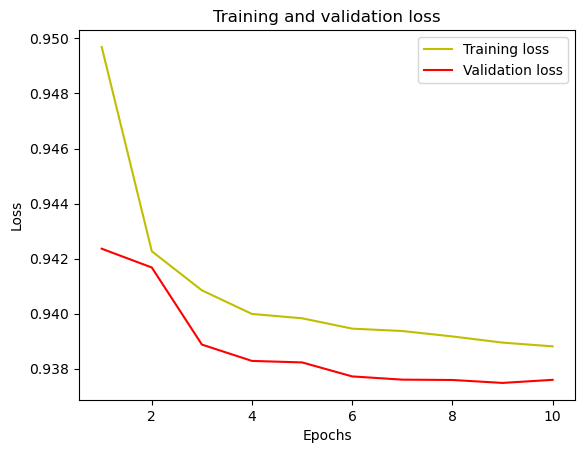

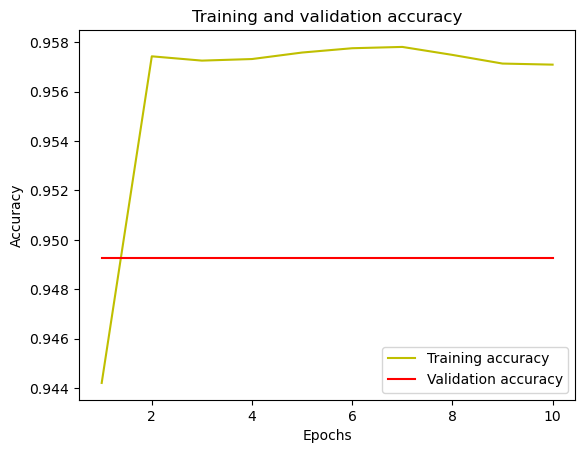

In [12]:
history = model.fit(train_generator, steps_per_epoch = len(img_train_set) // 2, epochs = 10, verbose = 1
                    , validation_data = val_generator, validation_steps = len(img_val_set) // 2)

model.save('my_model_1')

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
